# Homework 3 HW3: NBC, KNN, and Ensemble Learning

## 2021-0407 CIS 600 Fundamental Data & Knowledge Mining

### Tanay Nagireddy

#### May 26th, 2021

**Problem Statement**

In this homework assignment, you are going to use multiple machine learning algorithms, including naive
Bayes classifier, K Nearest Neighbor, Random Forest and Gradient Boosting Classifier to build a disease
diagnosis model. It is a binary classification problem to predict whether or not a patient has a certain
unspecified disease.

Report layout: as a rough guide, include at the very least the report title (with the author name and
date information), an executive summary, introduction, the main body of your report (with analysis,
results and interpretation for each required machine learning algorithm), and a conclusion section that
provide a high level summary of your findings and any lessons learned.

**Introduction**

This assignment utilizes personal information containing patient data. The data includes whether or not that patient possesses the disease. Through the assignment we were be able to gather enough insight and tell whether existing patients that have not yet been examined for the disease, or incomming future patients, may have the disease.

**Executive Summary**

Four classifiers, namely, Naive Bayes, K Nearest Neighbor, Random Forest, and Gradient Boosting are applied to patient data to be able to build a model that can identify whether an individual has a specific disease. From the analysis we can see that there is a tradeoff between computation and correct hyperparameter inputs. To test or iterate through many different hyperparameters efficiently, random search was applied to find an approximation of the best hyperparameters, after which, grid search was applied with the results of random search but a few values above and below to find the best score. The dataset was cleansed of outliers by removing those that were statistically considered an outlier (greater than 3 z-score). This was done on continuous data along with other pre-processing steps. With the finalized dataset, each classifier was setup and produced an overall score between 70-75%. We are more worried about the recall score, and RandomForest had the best recall score meaning that it had the lowest number of false negatives or falsely identifying patients that do have the disease as not having it. Gradient Boosting showed potential but was sub par due to inadequate tuning as compared to K Nearest Neighbor or Random Forest.

### Libraries and Data

 * importing required libraries

In [1]:
# data
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# graphing
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
import graphviz
from string import ascii_letters

# collection
from collections import Counter, OrderedDict, namedtuple
import itertools

# statistical
import math
from scipy import stats
from scipy.stats import normaltest, shapiro
import scipy.stats as ss

# modelling
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, KBinsDiscretizer, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV, KFold
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve, f1_score, classification_report, plot_confusion_matrix, plot_roc_curve, recall_score, precision_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz, export_text
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB, ComplementNB

In [2]:
# plots visualizations below cell
%matplotlib inline

In [3]:
# ignore warnings that appear for HTML output
import warnings
warnings.simplefilter('ignore')

In [4]:
# import training and testing data
data_train = pd.read_csv("Disease Prediction Training.csv")
data_test = pd.read_csv("Disease Prediction Testing.csv")

### Functions

The following functions provide a clean way to compute/conduct necessary data analysis, please see the function headers for information about each function.

In [5]:
def splitByType(df):
    """
    Description: computes two dataframes based on the type of the columns (int64, float64, object)
    Input: dataframe containing cleansed data
    Return: dataframe containing only object type columns, and dataframe excluding only object type columns 
    """
    non_object_type = df.select_dtypes(exclude=['object'])  # int64, float64, etc.
    object_type = df.select_dtypes(include=['object'])  # string, etc.
    return {'non_object_type':non_object_type, 'object_type':object_type}

In [6]:
def displayBoxPlots(df):
    """
    Description: plots the boxplots of features/attributes/columns
    Input: non_object_type dataframe (int64, float64, etc.) containing cleansed data
    Return: plot of box plots
    Reference: https://towardsdatascience.com/exploratory-data-analysis-8fc1cb20fd15
    """
    l = df.columns.values
    number_of_columns=7
    number_of_rows = len(l)-1/number_of_columns
    plt.figure(figsize=(number_of_columns,5*number_of_rows))
    for i in range(0,len(l)):
        plt.subplot(number_of_rows + 1,number_of_columns,i+1)
        sns.set_style('whitegrid')
        sns.boxplot(y=df[l[i]],color='green',orient='v')
        plt.tight_layout()

In [7]:
def displayDistribution(df):
    """
    Description: plots the distribution plots/histograms of features/attributes/columns
    Input: non_object_type dataframe (int64, float64, etc.) containing cleansed data
    Return: plot of distribution plots/histograms
    Reference: https://towardsdatascience.com/exploratory-data-analysis-8fc1cb20fd15
    """
    l = df.columns.values
    number_of_columns=7
    number_of_rows = len(l)-1/number_of_columns
    plt.figure(figsize=(2*number_of_columns,5*number_of_rows))
    for i in range(0,len(l)):
        plt.subplot(number_of_rows + 1,number_of_columns,i+1)
        sns.distplot(df[l[i]],kde=True)

In [8]:
def displayCorrelationHeatMap(df_corr):
    """
    Description: display a correlation matrix for the dataframe of correlation values (depending on the statistic)
    Input: dataframe of correlation values
    Result: heatmap of correlation matrix
    Reference: https://towardsdatascience.com/heatmap-basics-with-pythons-seaborn-fb92ea280a6c
    """
    plt.figure(figsize=(20,12))

    mask = np.triu(np.ones_like(df_corr, dtype=np.bool))

    mask = mask[1:, :-1]
    corr = df_corr.iloc[1:,:-1].copy()

    sns.heatmap(corr, mask=mask, cmap='viridis', annot=True)

In [9]:
def discretize_data(df, columns_, number_of_bins={}):
    """
    Description: Converts continous data into descrete bins.
    Input: Dataframe, features/columns, number of bins for each column
    Output: Discretized dataset
    """
    data = df.copy()
    
    for ind in range(len(columns_)):
    
        discretizer = KBinsDiscretizer(
            n_bins=number_of_bins[columns_[ind]], 
            encode='ordinal', 
            strategy='uniform'
        )

        feature_data = data[columns_[ind]]
        
        est = discretizer.fit_transform(feature_data.values.reshape(-1, 1))
        
        data_train_discretize = pd.DataFrame(
            est, 
            columns=[columns_[ind]]
        )

        data_train_discretize.reset_index(inplace=True)

        data.drop(
            inplace=True,
            columns=columns_[ind]
        )

        data.reset_index(inplace=True)

        data = data.join(data_train_discretize, on='index', how='inner', lsuffix='_main', rsuffix='_disc')

        data.drop(columns=['index','index_main','index_disc'], inplace=True)
    
    return data

In [10]:
def model_implementation(classifier, df_train_test, param_grid):
    """
    Description: Implementations a model by training the model, and running it on the validation set
    Input: model type, dataset, dictionary of parameter values for gridsearch
    Output: Prints a series of information including metrics and results of model
    """
    X = df_train_test.drop(columns=['Disease'])

    y = df_train_test['Disease']

    X_train, X_test, y_train, y_test = train_test_split(
        X, 
        y, 
        test_size=0.2, 
        random_state=1,
        shuffle=True,
        stratify=y
    )

    print(f"Training data size is {X_train.shape}, and Validation data size is {X_test.shape}\n")
    
    models = {
        'GaussianNB':GaussianNB(),
        'BernoulliNB':BernoulliNB(),
        'MultinomialNB':MultinomialNB(),
        'ComplementNB':ComplementNB(),
        'KNeighborsClassifier':KNeighborsClassifier(),
        'RandomForestClassifier':RandomForestClassifier(),
        'GradientBoostingClassifier':GradientBoostingClassifier()
    }
    
    grid = GridSearchCV(
        models[classifier],
        param_grid, 
        cv=3,  # stratified k fold used for cross validation
        scoring=[
            'accuracy',
            'f1',
            'roc_auc'
        ],
        n_jobs=-1,
        refit='f1',
        verbose=2
    )
    
    grid.fit(X_train, y_train)
    
    print(f"Training set best score: {grid.best_score_}\n") # f1-score

    print("Best parameters found: \n", grid.best_params_)

    print("Fitting best params to validation data set... \n")
    
    if classifier == 'GaussianNB':
        clf = GaussianNB(**grid.best_params_)
    if classifier == 'BernoulliNB':
        clf = BernoulliNB(**grid.best_params_)
    if classifier == 'MultinomialNB':
        clf = MultinomialNB(**grid.best_params_)
    if classifier == 'ComplementNB':
        clf = ComplementNB(**grid.best_params_)
    if classifier == 'KNeighborsClassifier':
        clf = KNeighborsClassifier(**grid.best_params_)
    if classifier == 'RandomForestClassifier':
        clf = RandomForestClassifier(**grid.best_params_)
    if classifier == 'GradientBoostingClassifier':
        clf = GradientBoostingClassifier(**grid.best_params_)
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_pred_prob = clf.predict_proba(X_test)
    
    if classifier == 'RandomForestClassifier':
        
        feature_imp = pd.DataFrame(
            clf.feature_importances_, index=X_train.columns,
            columns=['importance']
        ).sort_values('importance', ascending=False)
        
        print(feature_imp)
        
    if classifier == 'KNeighborsClassifier':
        
        neighbors = list(range(1, 50))
        train_results = []
        test_results = []
        for n in neighbors:
            model = KNeighborsClassifier(n_neighbors=n)
            model.fit(X_train, y_train)
            train_pred = model.predict(X_train)
            cv = KFold(n_splits=10, shuffle=True, random_state=16)  # repeated hold out accuracy
            acc = cross_val_score(model, X_train, y_train, cv=cv).mean()*100
            train_results.append(acc)
            y_pred = model.predict(X_test)
            acc_test = round(accuracy_score(y_test, y_pred)*100, 2)
            test_results.append(acc_test)

        line1, = plt.plot(neighbors, train_results, 'b', label="Train Accuracy")
        line2, = plt.plot(neighbors, test_results, 'r', label="Test Accuracy")
        plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
        plt.ylabel("Accuracy")
        plt.xlabel("n_neighbors")
        plt.show()
    
    print("Fitting complete")
    
    print_scores(y_test, y_pred, y_pred_prob)
    
    plot_confusion_matrix(clf, X_test, y_test)
    
    plot_roc_curve(clf, X_test, y_test)
    
    return grid.best_params_

In [11]:
def print_scores(y_test,y_pred,y_pred_prob):
    '''
    Description: Prints varies scores that quantify an algorithms performance
    Input: Class label data and class probabilites
    Output: Scores
    '''
    print("\nConfusion matrix:\n", confusion_matrix(y_test,y_pred))
    print("\nClassification report:\n", classification_report(y_test, y_pred))
    print("\nRecall score: ", recall_score(y_test,y_pred))
    print("\nPrecision score: ", precision_score(y_test,y_pred))
    print("\nF1 score: ", f1_score(y_test,y_pred))
    print("\nAccuracy score: ", accuracy_score(y_test,y_pred))
    print("\nROC AUC: {}".format(roc_auc_score(y_test, y_pred_prob[:,1])))

## Data preparation

### Summary statistics

 * displaying descriptive statistics like data set dimensions, data types, column information

In [12]:
print(f"Training data: {data_train.shape} and Testing data: {data_test.shape}")

print("\nNumber of attributes: \n non_object_type: {} \n object_type: {}".format(len(splitByType(data_train)['non_object_type'].columns), len(splitByType(data_train)['object_type'].columns)))

print("\nNon-Object Type data:\n" , splitByType(data_train)['non_object_type'].columns)

print("\nObject Type data:\n" ,splitByType(data_train)['object_type'].columns)

print("\nData Types:\n", Counter(data_train.dtypes))

print("\nTraining data: \n", data_train.head())

print("\nTraining set information:\n")
print(data_train.info())


Training data: (49000, 12) and Testing data: (21000, 12)

Number of attributes: 
 non_object_type: 9 
 object_type: 3

Non-Object Type data:
 Index(['Age', 'Height', 'Weight', 'High Blood Pressure', 'Low Blood Pressure',
       'Smoke', 'Alcohol', 'Exercise', 'Disease'],
      dtype='object')

Object Type data:
 Index(['Gender', 'Cholesterol', 'Glucose'], dtype='object')

Data Types:
 Counter({dtype('int64'): 8, dtype('O'): 3, dtype('float64'): 1})

Training data: 
    Age  Gender  Height  Weight  High Blood Pressure  Low Blood Pressure  \
0   59  female     167    88.0                  130                  68   
1   64  female     150    71.0                  140                 100   
2   41  female     166    83.0                  100                  70   
3   50    male     172   110.0                  130                  80   
4   39  female     162    61.0                  110                  80   

  Cholesterol Glucose  Smoke  Alcohol  Exercise  Disease  
0      normal  norm

From this display of information, we can see that there is a mixture of categorical, continuous, and binary data.

**Missing Values**

In [13]:
print(f"\nThere are a total of {data_train.isna().sum().sum()} missing values.\n")

print(f"Here is a breakdown by column for missing values by column (# of columns = {len(data_train.isna().sum())}): \n")
print(data_train.isna().sum())


There are a total of 0 missing values.

Here is a breakdown by column for missing values by column (# of columns = 12): 

Age                    0
Gender                 0
Height                 0
Weight                 0
High Blood Pressure    0
Low Blood Pressure     0
Cholesterol            0
Glucose                0
Smoke                  0
Alcohol                0
Exercise               0
Disease                0
dtype: int64


There are no missing values which is great.

**Duplicate Values**

In [14]:
data_train.duplicated().sum()

1752

In [15]:
data_train.drop_duplicates(inplace=True)

In [16]:
data_train.duplicated().sum()

0

In [17]:
data_train.shape

(47248, 12)

In [18]:
data_train.reset_index(drop=True, inplace=True)

After checking for duplicate values, we removed the ones that were found from our training dataset.

**Mapping**
Training Set

We will map all categorical data to numerical data for both the training and test dataset.

In [19]:
mapped_columns = splitByType(data_train)['object_type'].columns

In [20]:
for col in mapped_columns:
    data_train[col] = data_train[col].astype('category')
    code_col = col + "_codes"
    data_train[code_col] = data_train[col].cat.codes

In [21]:
data_train.drop(columns=mapped_columns, inplace=True)

**Mapping**
Testing Set

In [22]:
mapped_columns = splitByType(data_test)['object_type'].columns

In [23]:
for col in mapped_columns:
    data_test[col] = data_test[col].astype('category')
    code_col = col + "_codes"
    data_test[code_col] = data_test[col].cat.codes

In [24]:
data_test.drop(columns=mapped_columns, inplace=True)

### Data Visualization

We will render visuals to gather insights on outliers and spread of the data.

In [25]:
data_train.describe(include='all')

Age        Height        Weight  High Blood Pressure  \
count  47248.000000  47248.000000  47248.000000         47248.000000   
mean      52.863126    164.352735     74.442470           129.013461   
std        6.791208      8.314608     14.469526           150.324461   
min       29.000000     55.000000     10.000000          -150.000000   
25%       48.000000    159.000000     65.000000           120.000000   
50%       53.000000    165.000000     72.000000           120.000000   
75%       58.000000    170.000000     82.000000           140.000000   
max       64.000000    207.000000    200.000000         14020.000000   

       Low Blood Pressure         Smoke       Alcohol      Exercise  \
count        47248.000000  47248.000000  47248.000000  47248.000000   
mean            97.557209      0.091411      0.056235      0.799378   
std            204.020137      0.288196      0.230378      0.400470   
min              0.000000      0.000000      0.000000      0.000000   
25%             80.000000      0.000000      0.000000      1.000000   
50%             80.000000      0.000000      0.000000      1.000000   
75%             90.000000      0.000000      0.000000      1.000000   
max          11000.000000      1.000000      1.000000      1.000000   

            Disease  Gender_codes  Cholesterol_codes  Glucose_codes  
count  47248.000000  47248.000000       47248.000000   47248.000000  
mean       0.509567      0.354999           0.976740       1.001587  
std        0.499914      0.478518           0.509554       0.393797  
min        0.000000      0.000000           0.000000       0.000000  
25%        0.000000      0.000000           1.000000       1.000000  
50%        1.000000      0.000000           1.000000       1.000000  
75%        1.000000      1.000000           1.000000       1.000000  
max        1.000000      1.000000           2.000000       2.000000

From the basic statistics, we can see that:
 * there are some odd min and max values for features like high and low blood pressure
 * from the means, we can see that smoking, exercise, alcohol, and gender are skewed to one end

Let's look at the spread of these values.

**Box Plots**

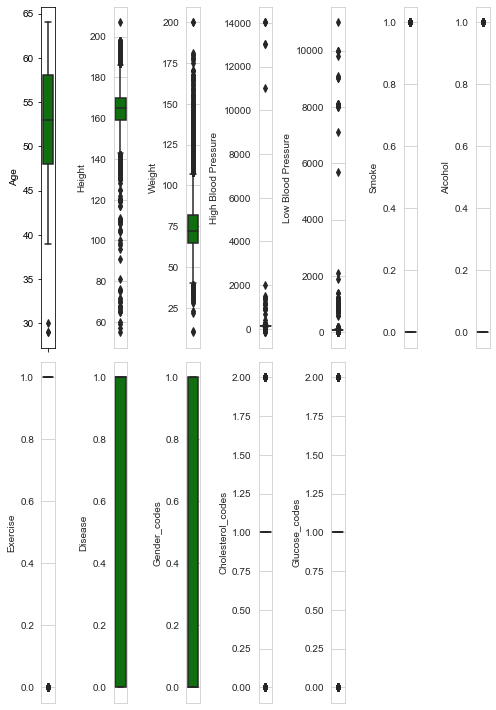

In [26]:
displayBoxPlots(data_train)

There are many outliers for features/attributes like high and low blood pressure, let's take a closer look and see how they can be handled.

**Unique Values**

In [27]:
for col in data_train.columns:
    print(data_train[col].value_counts())

55    2696
53    2575
57    2485
59    2436
56    2396
54    2396
49    2287
51    2280
58    2279
52    2162
60    2132
50    2129
63    1891
61    1888
64    1520
62    1503
47    1494
43    1429
45    1389
41    1297
48    1232
39    1174
40    1100
46    1095
44    1010
42     970
29       2
30       1
Name: Age, dtype: int64
165    3630
160    3220
170    3105
168    2923
164    2294
158    2201
162    2179
156    1888
169    1858
167    1746
163    1737
159    1409
172    1403
166    1355
157    1279
175    1234
155    1212
161    1204
174    1065
154    1002
171     935
178     831
176     802
152     802
173     754
150     730
153     729
180     595
151     438
177     337
179     283
149     249
182     218
148     205
185     164
147     143
181     137
184     115
183     113
146     105
145      98
186      73
187      54
144      47
188      37
140      36
143      34
189      26
190      26
120      25
142      21
141      14
198      11
130       9
191       8
192     

Rather than removing hundreds of data points that contain odd values as they are difficult to pinpoint, we are going to remove statistical outliers data rows in each of the continuous attributes through multiple rounds as seen in the following subsections.

***Round 1*** High and Low Blood Pressure

In [28]:
data_train.shape

(47248, 12)

In [29]:
data_out_rem_1 = data_train[(np.abs(stats.zscore(data_train['High Blood Pressure'])) < 3)]

In [30]:
data_out_rem_1 = data_out_rem_1[(np.abs(stats.zscore(data_out_rem_1['Low Blood Pressure'])) < 3)]

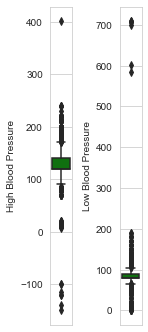

In [31]:
displayBoxPlots(data_out_rem_1[['High Blood Pressure', 'Low Blood Pressure']])

In [32]:
data_out_rem_1.shape

(46570, 12)

We can that some corrections has been done and data has been removed, but there are still some odd values, let's do another round.

***Round 2*** High and Low Blood Pressure

In [33]:
data_out_rem_2 = data_out_rem_1[(np.abs(stats.zscore(data_out_rem_1['High Blood Pressure'])) < 3)]

In [34]:
data_out_rem_2 = data_out_rem_2[(np.abs(stats.zscore(data_out_rem_2['Low Blood Pressure'])) < 3)]

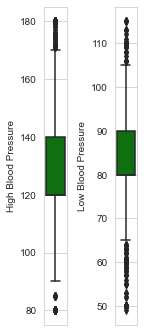

In [35]:
displayBoxPlots(data_out_rem_2[['High Blood Pressure', 'Low Blood Pressure']])

In [36]:
data_out_rem_2.shape

(46010, 12)

This is much better, we can move on to the other features.

#### *Height*

In [37]:
data_out_rem_3 = data_out_rem_2[(np.abs(stats.zscore(data_out_rem_2['Height'])) < 3)]

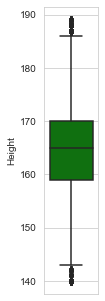

In [38]:
displayBoxPlots(data_out_rem_3[['Height']])

In [39]:
data_out_rem_3.shape

(45837, 12)

#### *Weight*

In [40]:
data_out_rem_4 = data_out_rem_3[(np.abs(stats.zscore(data_out_rem_3['Weight'])) < 3)]

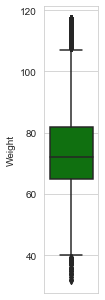

In [41]:
displayBoxPlots(data_out_rem_4[['Weight']])

In [42]:
data_out_rem_4.shape

(45424, 12)

#### *Age*

In [43]:
data_out_rem_5 = data_out_rem_4[(np.abs(stats.zscore(data_out_rem_4['Age'])) < 3)]

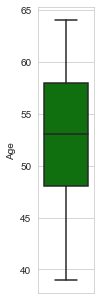

In [44]:
displayBoxPlots(data_out_rem_5[['Age']])

In [45]:
data_out_rem_5.shape

(45421, 12)

In [46]:
print(data_out_rem_5['Disease'].value_counts())

1    22742
0    22679
Name: Disease, dtype: int64


We can see that after removing the outliers, our class labels are extremely close which is great, meaning that this process has not created any skewness.

**Discretization**

We will not discretize the continuous features.

In [47]:
data_out_rem_5.reset_index(inplace=True, drop=True)

In [48]:
data_out_rem_5.head()

Age  Height  Weight  High Blood Pressure  Low Blood Pressure  Smoke  \
0   59     167    88.0                  130                  68      0   
1   64     150    71.0                  140                 100      0   
2   41     166    83.0                  100                  70      0   
3   50     172   110.0                  130                  80      1   
4   39     162    61.0                  110                  80      0   

   Alcohol  Exercise  Disease  Gender_codes  Cholesterol_codes  Glucose_codes  
0        0         1        0             0                  1              1  
1        0         0        1             0                  1              1  
2        1         1        0             0                  1              1  
3        0         1        0             1                  1              1  
4        0         1        0             0                  0              0

In [49]:
columns=[
    'Age',
    'Height', 
    'Weight',
    'High Blood Pressure',
    'Low Blood Pressure'
]

**Number of bins**

Using the freedman diaconis and the numpy method "histogram_bin_edges", we can decide the number of bins required for each attribute/feature.

In [50]:
print("Number of bins are as follows using the freedman diaconis estimator:\n")
num_of_bins = {}
for col in columns:
    bins = len(np.histogram_bin_edges(data_out_rem_5[col], bins='fd'))
    num_of_bins[col] = bins
print(num_of_bins)

Number of bins are as follows using the freedman diaconis estimator:

{'Age': 46, 'Height': 81, 'Weight': 91, 'High Blood Pressure': 91, 'Low Blood Pressure': 119}


**Descretization** Training Set

In [51]:
data_discretized = discretize_data(data_out_rem_5, columns_=columns, number_of_bins=num_of_bins)

In [52]:
data_discretized.head()

Smoke  Alcohol  Exercise  Disease  Gender_codes  Cholesterol_codes  \
0      0        0         1        0             0                  1   
1      0        0         0        1             0                  1   
2      0        1         1        0             0                  1   
3      1        0         1        0             1                  1   
4      0        0         1        0             0                  0   

   Glucose_codes   Age  Height  Weight  High Blood Pressure  \
0              1  36.0    44.0    59.0                 45.0   
1              1  45.0    16.0    41.0                 54.0   
2              1   3.0    42.0    54.0                 18.0   
3              1  20.0    52.0    83.0                 45.0   
4              0   0.0    36.0    31.0                 27.0   

   Low Blood Pressure  
0                34.0  
1                91.0  
2                37.0  
3                55.0  
4                55.0

**Descretization** Testing Set

In [53]:
print("Number of bins are as follows using the freedman diaconis estimator:\n")
num_of_bins = {}
for col in columns:
    bins = len(np.histogram_bin_edges(data_test[col], bins='fd'))
    num_of_bins[col] = bins
print(num_of_bins)

Number of bins are as follows using the freedman diaconis estimator:

{'Age': 50, 'Height': 235, 'Weight': 133, 'High Blood Pressure': 11044, 'Low Blood Pressure': 11823}


In [54]:
data_discretized_test = discretize_data(data_test, columns_=columns, number_of_bins=num_of_bins)

Let's see how the data looks post outlier removal and discretization.

**Distribution Plots**

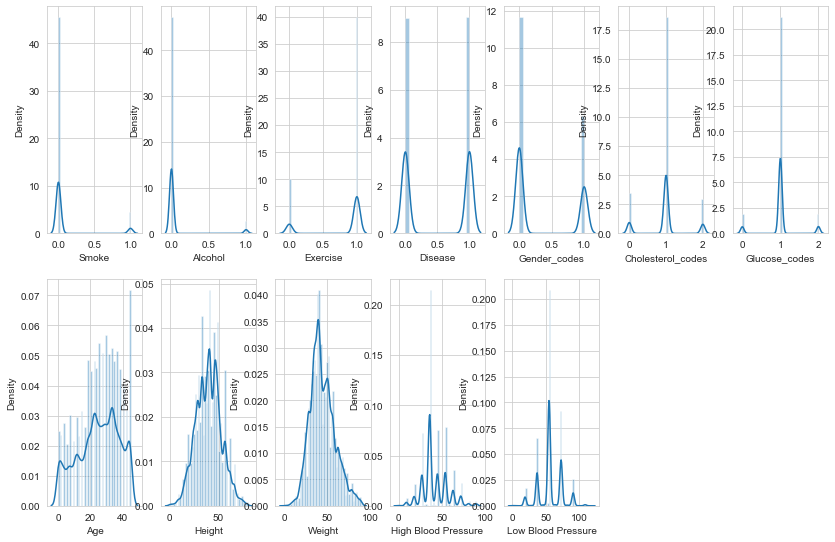

In [55]:
displayDistribution(data_discretized)

We can see that none of the features/attributes follow a gaussian-like distribution. Additionally, the disproportion of attributes is clearly visible, smoke, alcohol, exercise, gender_codes.

**Correlation Heat Maps**

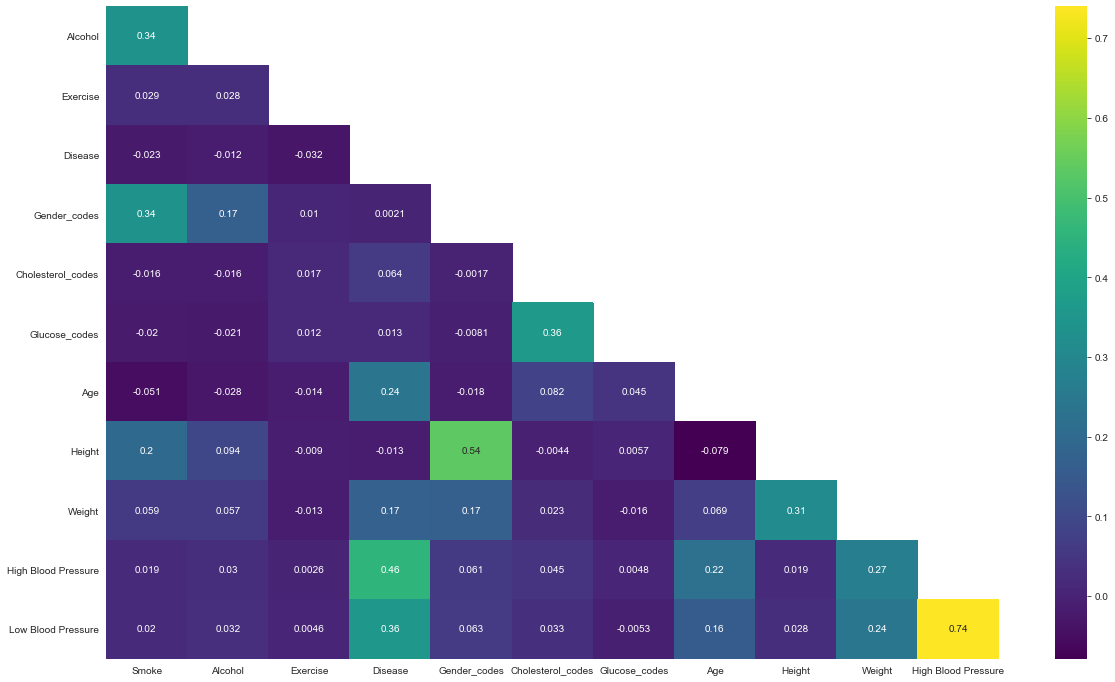

In [56]:
displayCorrelationHeatMap(data_discretized.corr(method='spearman'))

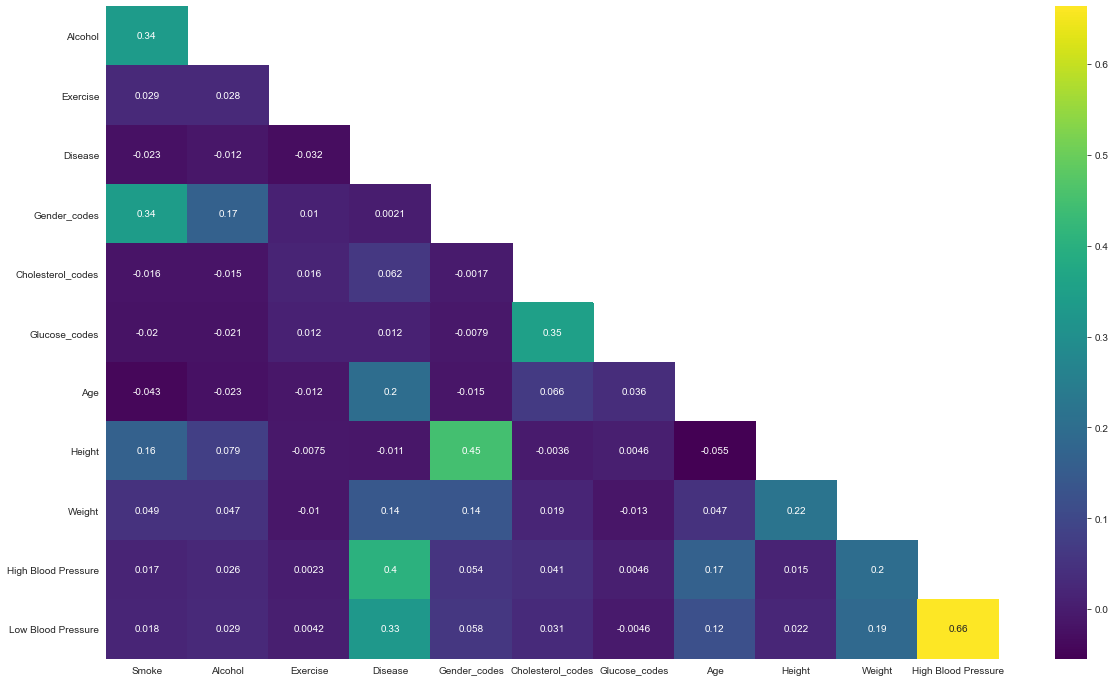

In [57]:
displayCorrelationHeatMap(data_discretized.corr(method='kendall'))

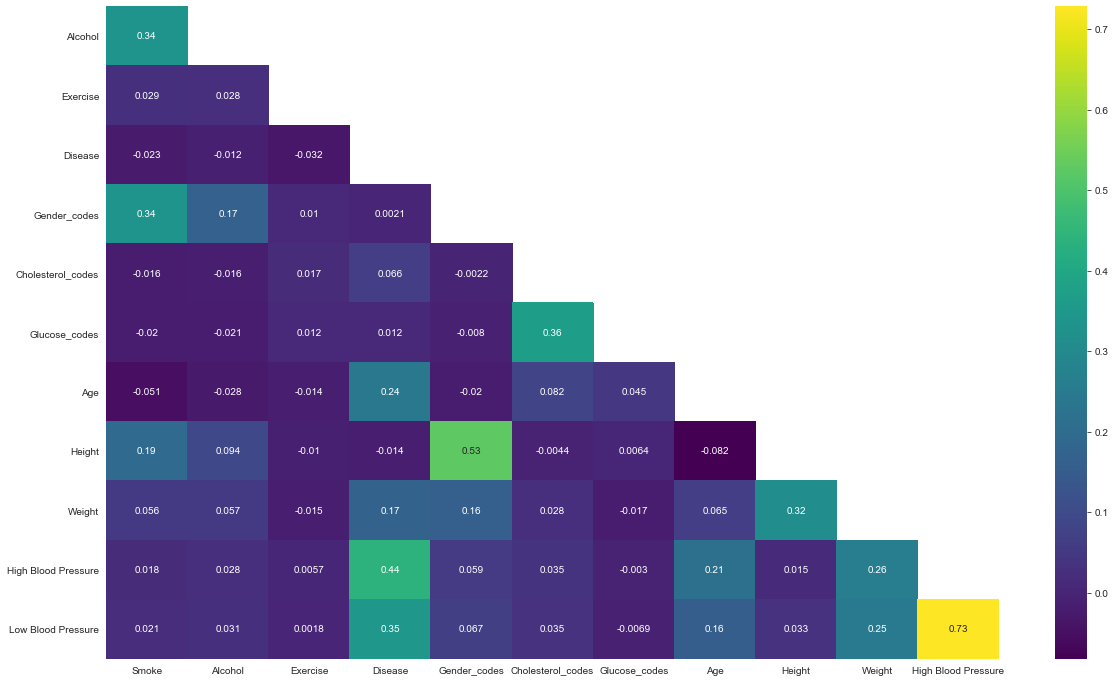

In [58]:
displayCorrelationHeatMap(data_discretized.corr(method='pearson'))

Through all the different methods, we can consistently see that some of the features/attributes have a strong correlation: 
 * A strong correlation between low and high blood pressure, not too surprising
 * Height and gender_codes seem to be correlated
 
These results suggest that a couple features my be disregarded/dropped.

**Pair Plots**

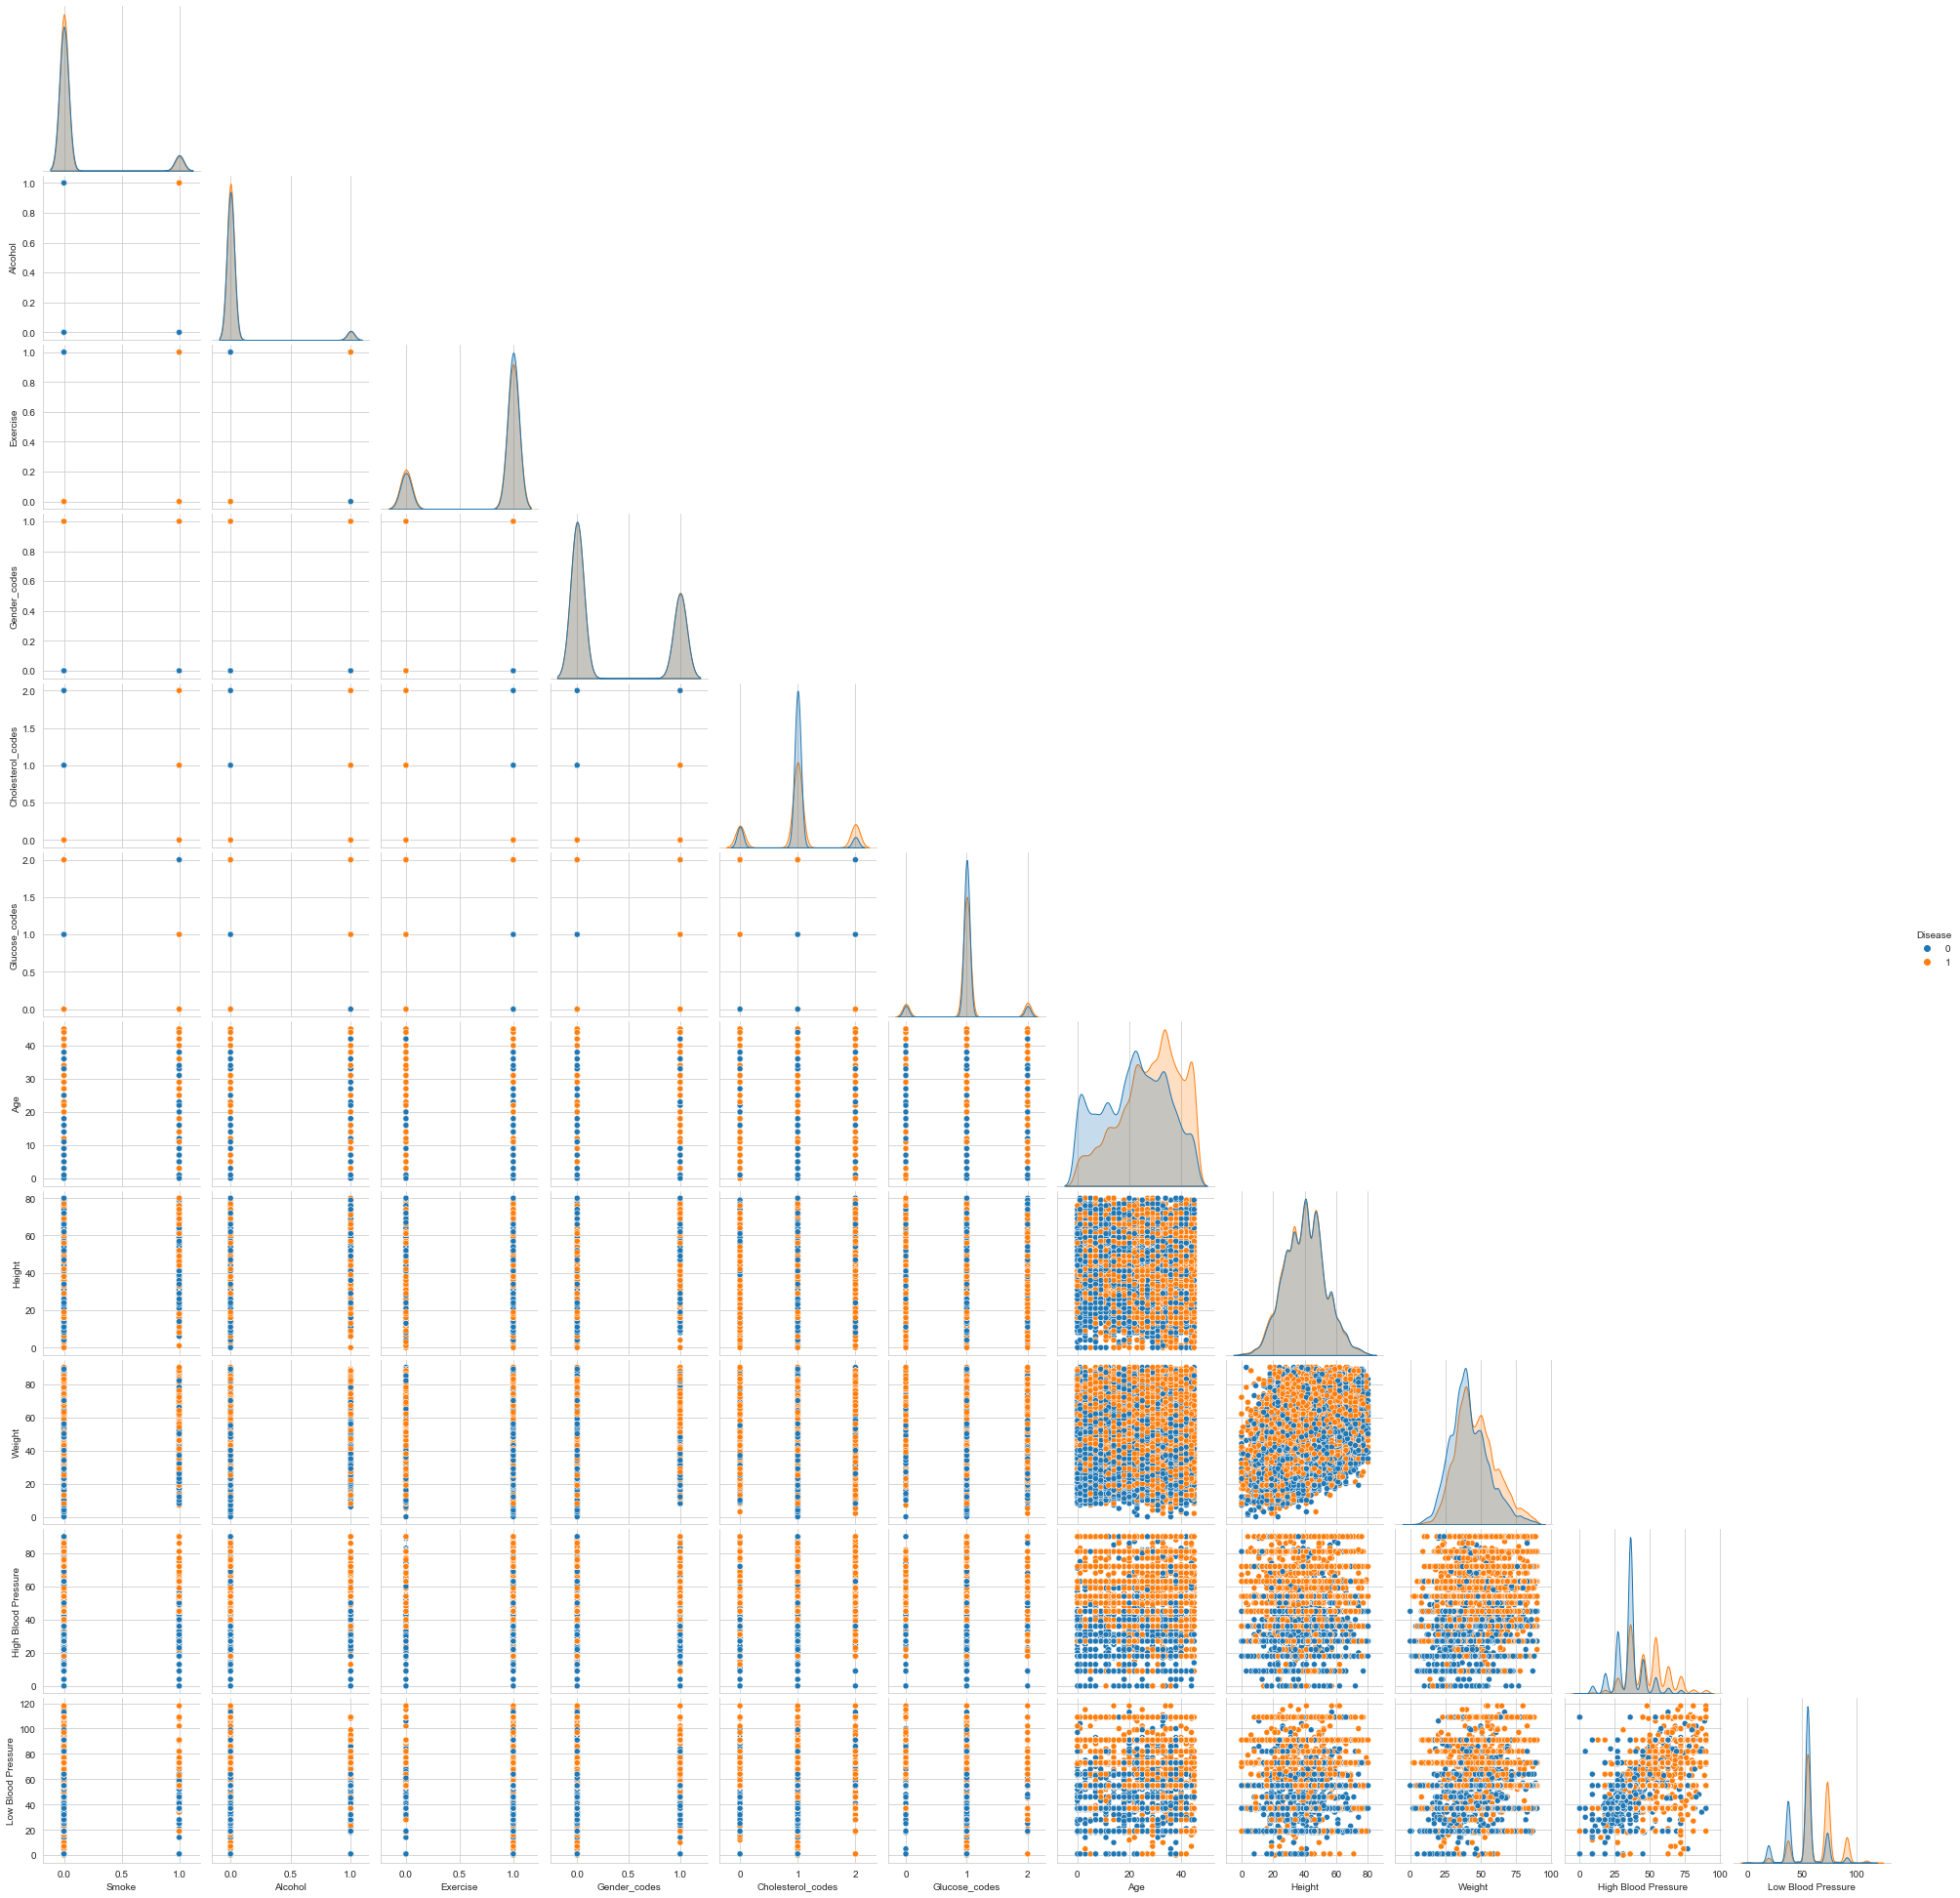

In [59]:
sns.pairplot(data_discretized, hue="Disease", corner=True)

From the pairplots we can see that there are distinctions between those that do have the disease and those that do not:
 * age - which shows a slight distinction with more older people having the disease rather than younger people. 
 * exercise - no exercise has far fewer people with the disease
 * smoke - follows exercise, no smoke with fewer people having the disease

Overall, there is a overlap between both of the disease classes.

**Feature Scaling - Standardization**

**Standardization** Training Set

In [60]:
standardized_est = StandardScaler().fit_transform(data_discretized)

data_standardized = pd.DataFrame(standardized_est, columns=data_discretized.columns)

data_standardized['Disease'] = data_standardized['Disease'].astype(int).map({-1:0,0:1})

data_standardized.head()

Smoke   Alcohol  Exercise  Disease  Gender_codes  Cholesterol_codes  \
0 -0.315714 -0.241394  0.501334        0     -0.737910           0.044688   
1 -0.315714 -0.241394 -1.994677        1     -0.737910           0.044688   
2 -0.315714  4.142600  0.501334        0     -0.737910           0.044688   
3  3.167420 -0.241394  0.501334        0      1.355178           0.044688   
4 -0.315714 -0.241394  0.501334        0     -0.737910          -1.931735   

   Glucose_codes       Age    Height    Weight  High Blood Pressure  \
0      -0.006592  0.884184  0.324937  1.034510             0.221365   
1      -0.006592  1.606408 -1.858042 -0.226986             0.842481   
2      -0.006592 -1.763969  0.169010  0.684094            -1.641982   
3      -0.006592 -0.399769  0.948645  2.716503             0.221365   
4      -2.565853 -2.004711 -0.298771 -0.927817            -1.020866   

   Low Blood Pressure  
0           -1.392946  
1            2.045097  
2           -1.211996  
3           -0.126298  
4           -0.126298

In [61]:
data_discretized.head()

Smoke  Alcohol  Exercise  Disease  Gender_codes  Cholesterol_codes  \
0      0        0         1        0             0                  1   
1      0        0         0        1             0                  1   
2      0        1         1        0             0                  1   
3      1        0         1        0             1                  1   
4      0        0         1        0             0                  0   

   Glucose_codes   Age  Height  Weight  High Blood Pressure  \
0              1  36.0    44.0    59.0                 45.0   
1              1  45.0    16.0    41.0                 54.0   
2              1   3.0    42.0    54.0                 18.0   
3              1  20.0    52.0    83.0                 45.0   
4              0   0.0    36.0    31.0                 27.0   

   Low Blood Pressure  
0                34.0  
1                91.0  
2                37.0  
3                55.0  
4                55.0

**Standardization** Testing Set

In [62]:
id_ = data_discretized_test['ID']

data_discretized_test.drop(columns=['ID'], inplace=True)

In [63]:
standardized_est_test = StandardScaler().fit_transform(data_discretized_test)

data_standardized_test = pd.DataFrame(standardized_est_test, columns=data_discretized_test.columns)

#data_standardized_test['Disease'] = data_standardized['Disease'].astype(int).map({-1:0,0:1})

#data_discretized_test['ID'] = id_
#data_standardized_test['ID'] = id_

data_standardized_test.head()

Smoke   Alcohol  Exercise  Gender_codes  Cholesterol_codes  \
0 -0.310262 -0.235785  0.492249     -0.732494          -1.955961   
1 -0.310262 -0.235785  0.492249     -0.732494           0.037689   
2 -0.310262 -0.235785  0.492249      1.365198           0.037689   
3 -0.310262 -0.235785 -2.031490     -0.732494           0.037689   
4 -0.310262 -0.235785  0.492249     -0.732494           0.037689   

   Glucose_codes       Age    Height    Weight  High Blood Pressure  \
0      -0.005758 -1.303867 -0.508442 -1.026790            -0.167478   
1      -0.005758 -1.718916  0.553839 -0.020290            -0.055293   
2      -2.578414  1.497715  0.457268  0.650711            -0.055293   
3      -0.005758  0.356330 -0.798155  2.328211             0.186335   
4      -0.005758  0.356330  0.360697 -0.523540            -0.055293   

   Low Blood Pressure  
0           -0.102552  
1           -0.162464  
2           -0.102552  
3            0.026489  
4           -0.102552

In [64]:
data_discretized_test.head()

Smoke  Alcohol  Exercise  Gender_codes  Cholesterol_codes  Glucose_codes  \
0      0        0         1             0                  0              1   
1      0        0         1             0                  1              1   
2      0        0         1             1                  1              0   
3      0        0         0             0                  1              1   
4      0        0         1             0                  1              1   

    Age  Height  Weight  High Blood Pressure  Low Blood Pressure  
0  21.0   121.0    31.0                 62.0               206.0  
1  17.0   132.0    43.0                 75.0               193.0  
2  48.0   131.0    51.0                 75.0               206.0  
3  37.0   118.0    71.0                103.0               234.0  
4  37.0   130.0    37.0                 75.0               206.0

We will now build and evaluate four classifiers.

## Naive Bayes

The first model that we will implement is Gaussian, followed by Bernoulli, then Complement and Multinomial.

Training data size is (36336, 11), and Validation data size is (9085, 11)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training set best score: 0.6940921547056006

Best parameters found: 
 {}
Fitting best params to validation data set... 

Fitting complete

Confusion matrix:
 [[3525 1011]
 [1641 2908]]

Classification report:
               precision    recall  f1-score   support

           0       0.68      0.78      0.73      4536
           1       0.74      0.64      0.69      4549

    accuracy                           0.71      9085
   macro avg       0.71      0.71      0.71      9085
weighted avg       0.71      0.71      0.71      9085


Recall score:  0.6392613761266213

Precision score:  0.7420260270477163

F1 score:  0.6868209730751064

Accuracy score:  0.7080902586681342

ROC AUC: 0.7753870697786944


{}

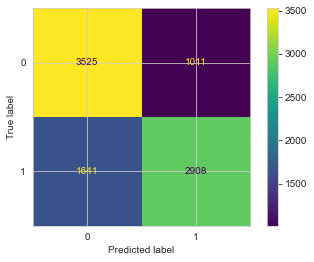

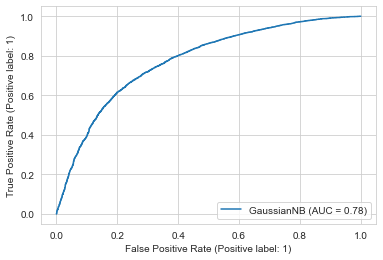

In [65]:
model_implementation('GaussianNB', data_discretized, {})

 * We would ideally like recall to be higher the lower score of 64% means that there were a significant number of false negatives.
 * The precision is not terrible but could be better, and says that 74% of those who had the disease were correctly identified has having the disease.
 * From the ROC AUC curve, we can say that our model has a 78% chance of distinguishing a person of having the disease (positive label: 1).

***Now the same with standardized data***

Training data size is (36336, 11), and Validation data size is (9085, 11)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training set best score: 0.6940921547056006

Best parameters found: 
 {}
Fitting best params to validation data set... 

Fitting complete

Confusion matrix:
 [[3525 1011]
 [1641 2908]]

Classification report:
               precision    recall  f1-score   support

           0       0.68      0.78      0.73      4536
           1       0.74      0.64      0.69      4549

    accuracy                           0.71      9085
   macro avg       0.71      0.71      0.71      9085
weighted avg       0.71      0.71      0.71      9085


Recall score:  0.6392613761266213

Precision score:  0.7420260270477163

F1 score:  0.6868209730751064

Accuracy score:  0.7080902586681342

ROC AUC: 0.7753872151679364


{}

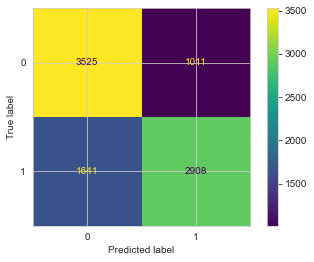

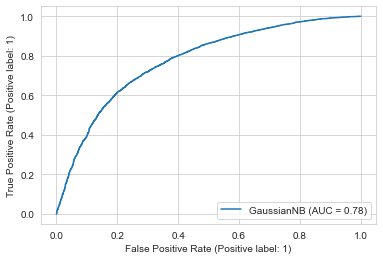

In [66]:
model_implementation('GaussianNB', data_standardized, {})

We can see that there is no difference between the discretized or standardized sets.

**Bernoulli**

Training data size is (36336, 11), and Validation data size is (9085, 11)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training set best score: 0.6823425770754818

Best parameters found: 
 {}
Fitting best params to validation data set... 

Fitting complete

Confusion matrix:
 [[3536 1000]
 [1726 2823]]

Classification report:
               precision    recall  f1-score   support

           0       0.67      0.78      0.72      4536
           1       0.74      0.62      0.67      4549

    accuracy                           0.70      9085
   macro avg       0.71      0.70      0.70      9085
weighted avg       0.71      0.70      0.70      9085


Recall score:  0.6205759507584084

Precision score:  0.7384253204289825

F1 score:  0.6743908265647396

Accuracy score:  0.6999449642267473

ROC AUC: 0.7586377929447835


{}

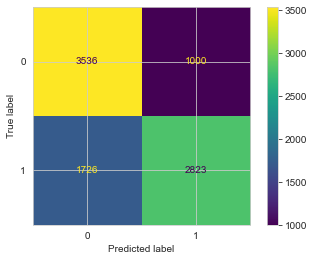

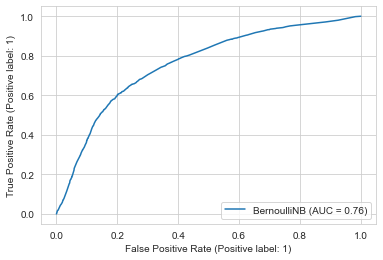

In [67]:
model_implementation('BernoulliNB', data_standardized, {})

We can that the score are very close if not the same, and it's slightly lower 62% for recall which is not great. Overall, Gaussian performed better and had smaller difference between the recall score of the positive vs the negative class.

**Complement**

In [68]:
param_grid = {'alpha':[0.0, 0.5, 1.0]}

Training data size is (36336, 11), and Validation data size is (9085, 11)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Training set best score: 0.6390840914693354

Best parameters found: 
 {'alpha': 0.0}
Fitting best params to validation data set... 

Fitting complete

Confusion matrix:
 [[2933 1603]
 [1714 2835]]

Classification report:
               precision    recall  f1-score   support

           0       0.63      0.65      0.64      4536
           1       0.64      0.62      0.63      4549

    accuracy                           0.63      9085
   macro avg       0.63      0.63      0.63      9085
weighted avg       0.63      0.63      0.63      9085


Recall score:  0.6232138931633326

Precision score:  0.638801261829653

F1 score:  0.6309113163458329

Accuracy score:  0.6348926802421574

ROC AUC: 0.6844751283593152


{'alpha': 0.0}

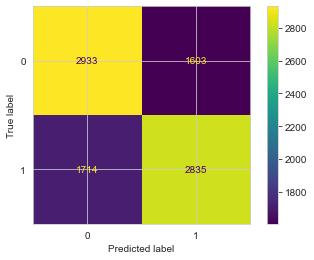

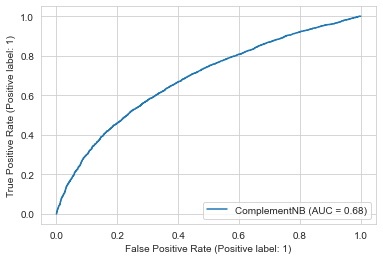

In [69]:
model_implementation('ComplementNB', data_discretized, param_grid)

Complement showed a lackluster performance compared to above, with much lower scores and no difference between the positive and negative class.

**Multinomial**

Training data size is (36336, 11), and Validation data size is (9085, 11)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Training set best score: 0.6392193189684644

Best parameters found: 
 {'alpha': 0.0}
Fitting best params to validation data set... 

Fitting complete

Confusion matrix:
 [[2932 1604]
 [1711 2838]]

Classification report:
               precision    recall  f1-score   support

           0       0.63      0.65      0.64      4536
           1       0.64      0.62      0.63      4549

    accuracy                           0.64      9085
   macro avg       0.64      0.64      0.64      9085
weighted avg       0.64      0.64      0.64      9085


Recall score:  0.6238733787645636

Precision score:  0.6389013957676722

F1 score:  0.631297964631298

Accuracy score:  0.6351128233351678

ROC AUC: 0.6844751283593152


{'alpha': 0.0}

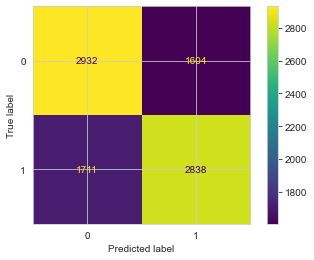

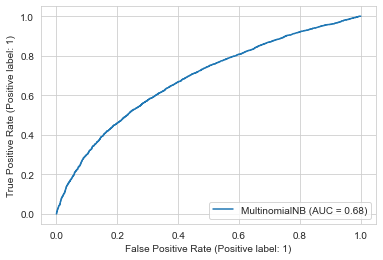

In [70]:
model_implementation('MultinomialNB', data_discretized, param_grid)

Multinomial followed Complement's performance.

### Prediction

In [71]:
clf_test_unseen = GaussianNB()  # best performing naive bayes classifier

In [72]:
X = data_standardized.drop(columns=['Disease'])

y = data_standardized['Disease']

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=1,
    shuffle=True,
    stratify=y
)

In [73]:
clf_test_unseen.fit(X_train, y_train)

GaussianNB()

In [74]:
y_pred_nb = clf_test_unseen.predict(data_standardized_test)

## K Nearest Neighbor

We will use random search to narrow down the criteria and then apply grid search to identify the best value for each criterion.

In [75]:
# Create the random grid
random_grid = {
    'n_neighbors':[10, 20, 30, 40, 50],
    'weights':['uniform','distance'],
    'algorithm':['ball_tree','kd_tree','brute'],
    'leaf_size':[5, 10, 15, 20, 25, 30],
    'metric':['manhattan','minkowski'], # for all real values
    'n_jobs':[-1]
    }

In [76]:
knn = KNeighborsClassifier()

In [77]:
knn_random = RandomizedSearchCV(estimator = knn, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=1, n_jobs = -1)

In [78]:
X = data_discretized.drop(columns=['Disease'])

y = data_discretized['Disease']

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=1,
    shuffle=True,
    stratify=y
)

In [79]:
knn_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=KNeighborsClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'algorithm': ['ball_tree', 'kd_tree',
                                                      'brute'],
                                        'leaf_size': [5, 10, 15, 20, 25, 30],
                                        'metric': ['manhattan', 'minkowski'],
                                        'n_jobs': [-1],
                                        'n_neighbors': [10, 20, 30, 40, 50],
                                        'weights': ['uniform', 'distance']},
                   random_state=1, verbose=2)

In [80]:
knn_random.best_params_

{'weights': 'uniform',
 'n_neighbors': 50,
 'n_jobs': -1,
 'metric': 'manhattan',
 'leaf_size': 25,
 'algorithm': 'brute'}

In [81]:
param_grid = {
    'n_neighbors':[40, 50, 60],
    'weights':['uniform'],
    'algorithm':['ball_tree'],
    'leaf_size':[5, 10, 20, 25, 30],
    'metric':['manhattan'],
    'n_jobs':[-1]
}

Training data size is (36336, 11), and Validation data size is (9085, 11)

Fitting 3 folds for each of 15 candidates, totalling 45 fits
Training set best score: 0.7065315191035135

Best parameters found: 
 {'algorithm': 'ball_tree', 'leaf_size': 20, 'metric': 'manhattan', 'n_jobs': -1, 'n_neighbors': 50, 'weights': 'uniform'}
Fitting best params to validation data set... 



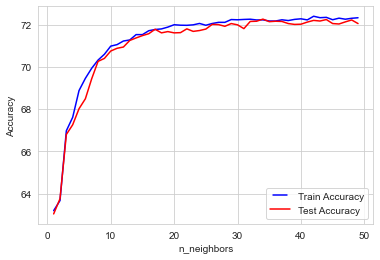

Fitting complete

Confusion matrix:
 [[3466 1070]
 [1469 3080]]

Classification report:
               precision    recall  f1-score   support

           0       0.70      0.76      0.73      4536
           1       0.74      0.68      0.71      4549

    accuracy                           0.72      9085
   macro avg       0.72      0.72      0.72      9085
weighted avg       0.72      0.72      0.72      9085


Recall score:  0.6770718839305342

Precision score:  0.7421686746987952

F1 score:  0.7081273709621797

Accuracy score:  0.7205283434232251

ROC AUC: 0.7845511960106742


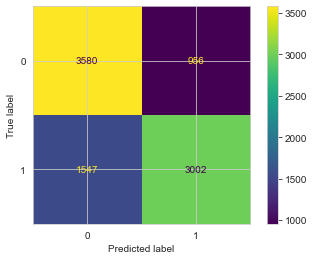

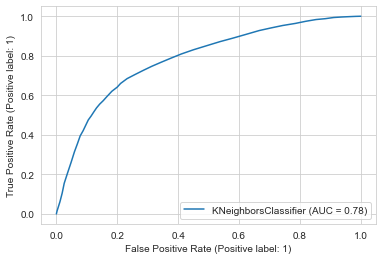

In [82]:
best_params_knn = model_implementation('KNeighborsClassifier', data_standardized, param_grid)

Although KNearestNeighbor has the same AUC as GaussianNB at 78%, the higher recall score would make KNearestNeighbor more preferrable over GuassianNB in our use case. Aditionally, precision for KNearestNeighbor is higher.

### Prediction

In [83]:
clf_test_unseen = KNeighborsClassifier(**best_params_knn)

In [84]:
X = data_standardized.drop(columns=['Disease'])

y = data_standardized['Disease']

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=1,
    shuffle=True,
    stratify=y
)

In [85]:
clf_test_unseen.fit(X_train, y_train)

KNeighborsClassifier(algorithm='ball_tree', leaf_size=20, metric='manhattan',
                     n_jobs=-1, n_neighbors=50)

In [86]:
y_pred_knn = clf_test_unseen.predict(data_standardized_test)

## Random Forest

References
 * https://towardsdatascience.com/improving-random-forest-in-python-part-1-893916666cd
 * https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

The following is taken from Will Koehrsen, the author of the work above to identify the approximate hyperparameter values to use using the random search cv process:

In [87]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
random_grid

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True, False]}

In [88]:
rfc = RandomForestClassifier()

In [89]:
rfc_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=1, n_jobs = -1)

In [90]:
X = data_discretized.drop(columns=['Disease'])

y = data_discretized['Disease']

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=1,
    shuffle=True,
    stratify=y
)

In [91]:
rfc_random.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=1, verbose=2)

In [92]:
rfc_random.best_params_

{'n_estimators': 1000,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': True}

In [93]:
param_grid = {
 'n_estimators': [100, 200, 300],
 'min_samples_split': [2, 3, 4, 5],
 'min_samples_leaf': [1, 2, 3, 5],
 'max_features': ['sqrt'],
 'max_depth': [8, 9, 10, 11, 12],
 'bootstrap': [True],
 'verbose':[3]
}

Training data size is (36336, 11), and Validation data size is (9085, 11)

Fitting 3 folds for each of 240 candidates, totalling 720 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 300
building tree 2 of 300
building tree 3 of 300
building tree 4 of 300
building tree 5 of 300
building tree 6 of 300
building tree 7 of 300
building tree 8 of 300
building tree 9 of 300
building tree 10 of 300
building tree 11 of 300
building tree 12 of 300
building tree 13 of 300
building tree 14 of 300
building tree 15 of 300
building tree 16 of 300
building tree 17 of 300
building tree 18 of 300
building tree 19 of 300
building tree 20 of 300
building tree 21 of 300
building tree 22 of 300
building tree 23 of 300
building tree 24 of 300
building tree 25 of 300
building tree 26 of 300
building tree 27 of 300
building tree 28 of 300
building tree 29 of 300
building tree 30 of 300
building tree 31 of 300
building tree 32 of 300
building tree 33 of 300
building tree 34 of 300
building tree 35 of 300
building tree 36 of 300
building tree 37 of 300
building tree 38 of 300
building tree 39 of 300
building tree 40 of 300
building tree 41 of 300
building tree 42 of 300
b

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    4.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


Training set best score: 0.7212517523377269

Best parameters found: 
 {'bootstrap': True, 'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 300, 'verbose': 3}
Fitting best params to validation data set... 

building tree 1 of 300
building tree 2 of 300
building tree 3 of 300
building tree 4 of 300
building tree 5 of 300
building tree 6 of 300
building tree 7 of 300
building tree 8 of 300
building tree 9 of 300
building tree 10 of 300
building tree 11 of 300
building tree 12 of 300
building tree 13 of 300
building tree 14 of 300
building tree 15 of 300
building tree 16 of 300
building tree 17 of 300
building tree 18 of 300
building tree 19 of 300
building tree 20 of 300
building tree 21 of 300
building tree 22 of 300
building tree 23 of 300
building tree 24 of 300
building tree 25 of 300
building tree 26 of 300
building tree 27 of 300
building tree 28 of 300
building tree 29 of 300
building tree 30 of 300
building tree 31 of 300
buil

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    4.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


                     importance
High Blood Pressure    0.444142
Low Blood Pressure     0.171289
Age                    0.138966
Cholesterol_codes      0.079638
Weight                 0.072860
Height                 0.049408
Glucose_codes          0.014626
Exercise               0.011336
Gender_codes           0.007663
Smoke                  0.005892
Alcohol                0.004180
Fitting complete

Confusion matrix:
 [[3503 1033]
 [1428 3121]]

Classification report:
               precision    recall  f1-score   support

           0       0.71      0.77      0.74      4536
           1       0.75      0.69      0.72      4549

    accuracy                           0.73      9085
   macro avg       0.73      0.73      0.73      9085
weighted avg       0.73      0.73      0.73      9085


Recall score:  0.6860848538140251

Precision score:  0.7513240250361097

F1 score:  0.7172239457658277

Accuracy score:  0.7291139240506329

ROC AUC: 0.7947207373134317


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.2s finished


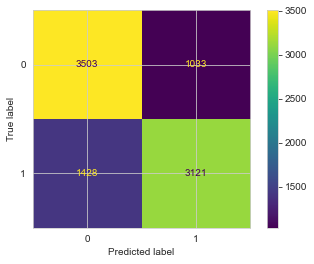

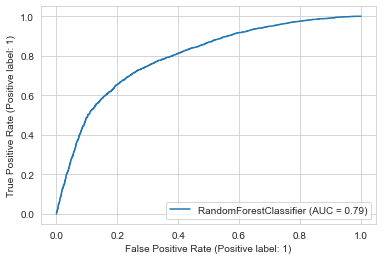

In [94]:
best_params_rf = model_implementation('RandomForestClassifier', data_discretized, param_grid=param_grid)

So far, RandomForest proves to the best performer with higher scores in general including AUC at 79%.
Let's see if GradientBoosting performs better than RandomForest. From the feature importance list, we can see that High Blood Pressure was the most important feature, while alcohol was the least important.

### Prediction

In [95]:
clf_test_unseen = RandomForestClassifier(**best_params_rf)

In [96]:
X = data_discretized.drop(columns=['Disease'])

y = data_discretized['Disease']

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=1,
    shuffle=True,
    stratify=y
)

In [97]:
clf_test_unseen.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 300
building tree 2 of 300
building tree 3 of 300
building tree 4 of 300
building tree 5 of 300
building tree 6 of 300
building tree 7 of 300
building tree 8 of 300
building tree 9 of 300
building tree 10 of 300
building tree 11 of 300
building tree 12 of 300
building tree 13 of 300
building tree 14 of 300
building tree 15 of 300
building tree 16 of 300
building tree 17 of 300
building tree 18 of 300
building tree 19 of 300
building tree 20 of 300
building tree 21 of 300
building tree 22 of 300
building tree 23 of 300
building tree 24 of 300
building tree 25 of 300
building tree 26 of 300
building tree 27 of 300
building tree 28 of 300
building tree 29 of 300
building tree 30 of 300
building tree 31 of 300
building tree 32 of 300
building tree 33 of 300
building tree 34 of 300
building tree 35 of 300
building tree 36 of 300
building tree 37 of 300
building tree 38 of 300
building tree 39 of 300
building tree 40 of 300
building tree 41 of 300
building tree 42 of 300
b

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    4.5s finished


RandomForestClassifier(max_depth=12, max_features='sqrt', min_samples_leaf=5,
                       min_samples_split=5, n_estimators=300, verbose=3)

In [98]:
y_pred_rf = clf_test_unseen.predict(data_discretized_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.3s finished


## Gradient Boosting

Following the Random Forst model, we will set up the random search cv process to identify optimal parameter values and then test other values around these to get the best model using grid search cv. 

In [100]:
# Number of trees in gradient boosting classifier
n_estimators = [100, 200, 500]  #[int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# "The function to measure the quality of a split."
criterion = ['friedman_mse', 'mse', 'mae']

# Number of features to consider at every split
max_features = ['sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3, 4, 5]

# Method of selecting samples for training each tree
#bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'criterion':criterion,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'learning_rate': np.arange(0.02, 0.1, 0.02),
               'verbose':[3]
              }

random_grid

gbc = GradientBoostingClassifier()

In [101]:
gbc_random = RandomizedSearchCV(estimator = gbc, param_distributions = random_grid, n_iter = 1, cv = 2, verbose=2, random_state=2, n_jobs = -1)

In [102]:
X = data_discretized.drop(columns=['Disease'])

y = data_discretized['Disease']

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y,
    test_size=0.2, 
    random_state=1,
    shuffle=True,
    stratify=y
)

In [ ]:
gbc_random.fit(X_train, y_train)

In [ ]:
gbc_random.best_params_

In [104]:
param_grid = {
 'n_estimators': [1000],
 'criterion': ['mse', 'mae'],
 'min_samples_split': [10],
 'min_samples_leaf': [3],
 'max_features': ['sqrt'],
 'max_depth': [10],
 'verbose':[3]
}

Training data size is (36336, 11), and Validation data size is (9085, 11)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
      Iter       Train Loss   Remaining Time 
         1           1.3310           45.83s
         2           1.2839           45.79s
         3           1.2440           46.41s
         4           1.2102           46.45s
         5           1.1806           47.24s
         6           1.1562           46.59s
         7           1.1343           46.83s
         8           1.1158           46.25s
         9           1.0989           46.23s
        10           1.0841           46.50s
        11           1.0703           46.72s
        12           1.0593           46.80s
        13           1.0491           46.57s
        14           1.0398           46.15s
        15           1.0316           45.91s
        16           1.0245           45.57s
        17           1.0175           45.56s
        18           1.0111           45.38s
        19

       183           0.7241           30.88s
       184           0.7233           30.84s
       185           0.7223           30.79s
       186           0.7205           30.78s
       187           0.7187           30.76s
       188           0.7173           30.73s
       189           0.7168           30.67s
       190           0.7159           30.61s
       191           0.7136           30.61s
       192           0.7116           30.60s
       193           0.7109           30.54s
       194           0.7092           30.54s
       195           0.7077           30.53s
       196           0.7057           30.54s
       197           0.7045           30.50s
       198           0.7032           30.48s
       199           0.7023           30.43s
       200           0.7015           30.38s
       201           0.7000           30.35s
       202           0.6984           30.33s
       203           0.6968           30.32s
       204           0.6959           30.26s
       205

       370           0.5253           24.71s
       371           0.5241           24.68s
       372           0.5235           24.65s
       373           0.5226           24.61s
       374           0.5220           24.57s
       375           0.5212           24.54s
       376           0.5201           24.51s
       377           0.5193           24.48s
       378           0.5181           24.44s
       379           0.5172           24.41s
       380           0.5162           24.38s
       381           0.5154           24.34s
       382           0.5142           24.32s
       383           0.5132           24.29s
       384           0.5126           24.24s
       385           0.5117           24.21s
       386           0.5106           24.18s
       387           0.5098           24.14s
       388           0.5088           24.11s
       389           0.5079           24.07s
       390           0.5066           24.05s
       391           0.5058           24.01s
       392

       556           0.3892           17.88s
       557           0.3882           17.85s
       558           0.3872           17.82s
       559           0.3865           17.78s
       560           0.3857           17.75s
       561           0.3854           17.70s
       562           0.3846           17.67s
       563           0.3841           17.63s
       564           0.3836           17.58s
       565           0.3832           17.54s
       566           0.3827           17.50s
       567           0.3820           17.46s
       568           0.3813           17.43s
       569           0.3806           17.39s
       570           0.3803           17.35s
       571           0.3797           17.31s
       572           0.3790           17.28s
       573           0.3786           17.24s
       574           0.3777           17.20s
       575           0.3771           17.17s
       576           0.3764           17.13s
       577           0.3762           17.09s
       578

       744           0.2925           10.54s
       745           0.2921           10.50s
       746           0.2918           10.46s
       747           0.2912           10.42s
       748           0.2910           10.38s
       749           0.2905           10.34s
       750           0.2899           10.30s
       751           0.2894           10.26s
       752           0.2889           10.22s
       753           0.2884           10.18s
       754           0.2881           10.14s
       755           0.2877           10.10s
       756           0.2873           10.05s
       757           0.2870           10.01s
       758           0.2865            9.97s
       759           0.2861            9.93s
       760           0.2855            9.89s
       761           0.2853            9.85s
       762           0.2849            9.81s
       763           0.2845            9.77s
       764           0.2841            9.73s
       765           0.2838            9.69s
       766

       927           0.2285            3.05s
       928           0.2280            3.00s
       929           0.2278            2.96s
       930           0.2274            2.92s
       931           0.2271            2.88s
       932           0.2269            2.84s
       933           0.2266            2.80s
       934           0.2264            2.75s
       935           0.2261            2.71s
       936           0.2259            2.67s
       937           0.2256            2.63s
       938           0.2250            2.59s
       939           0.2248            2.55s
       940           0.2245            2.51s
       941           0.2242            2.46s
       942           0.2239            2.42s
       943           0.2237            2.38s
       944           0.2235            2.34s
       945           0.2233            2.30s
       946           0.2231            2.26s
       947           0.2227            2.22s
       948           0.2225            2.17s
       949

       106           0.8168           33.44s
       107           0.8150           33.39s
       108           0.8127           33.38s
       109           0.8111           33.32s
       110           0.8093           33.29s
       111           0.8074           33.25s
       112           0.8050           33.27s
       113           0.8033           33.24s
       114           0.8011           33.23s
       115           0.7994           33.18s
       116           0.7978           33.12s
       117           0.7972           33.03s
       118           0.7962           32.96s
       119           0.7945           32.93s
       120           0.7921           32.92s
       121           0.7902           32.89s
       122           0.7897           32.77s
       123           0.7878           32.74s
       124           0.7856           32.73s
       125           0.7836           32.72s
       126           0.7822           32.66s
       127           0.7808           32.61s
       128

       294           0.5925           26.07s
       295           0.5916           26.02s
       296           0.5913           25.96s
       297           0.5900           25.94s
       298           0.5890           25.91s
       299           0.5878           25.88s
       300           0.5869           25.85s
       301           0.5863           25.81s
       302           0.5861           25.74s
       303           0.5856           25.70s
       304           0.5846           25.67s
       305           0.5835           25.63s
       306           0.5826           25.59s
       307           0.5813           25.57s
       308           0.5806           25.53s
       309           0.5790           25.52s
       310           0.5779           25.48s
       311           0.5763           25.47s
       312           0.5747           25.46s
       313           0.5738           25.43s
       314           0.5725           25.40s
       315           0.5716           25.37s
       316

       481           0.4346           19.81s
       482           0.4341           19.77s
       483           0.4335           19.74s
       484           0.4328           19.70s
       485           0.4321           19.66s
       486           0.4315           19.63s
       487           0.4312           19.59s
       488           0.4305           19.55s
       489           0.4298           19.51s
       490           0.4288           19.49s
       491           0.4285           19.44s
       492           0.4276           19.41s
       493           0.4267           19.38s
       494           0.4263           19.34s
       495           0.4254           19.31s
       496           0.4246           19.27s
       497           0.4244           19.23s
       498           0.4238           19.19s
       499           0.4230           19.16s
       500           0.4222           19.13s
       501           0.4214           19.09s
       502           0.4206           19.06s
       503

       667           0.3252           13.13s
       668           0.3248           13.09s
       669           0.3243           13.06s
       670           0.3239           13.02s
       671           0.3232           12.99s
       672           0.3230           12.95s
       673           0.3225           12.91s
       674           0.3219           12.87s
       675           0.3216           12.84s
       676           0.3213           12.80s
       677           0.3210           12.76s
       678           0.3208           12.72s
       679           0.3202           12.68s
       680           0.3200           12.64s
       681           0.3196           12.60s
       682           0.3189           12.57s
       683           0.3187           12.53s
       684           0.3184           12.49s
       685           0.3180           12.45s
       686           0.3172           12.42s
       687           0.3167           12.38s
       688           0.3165           12.34s
       689

       852           0.2478            6.01s
       853           0.2475            5.97s
       854           0.2472            5.93s
       855           0.2470            5.89s
       856           0.2468            5.85s
       857           0.2462            5.81s
       858           0.2458            5.77s
       859           0.2455            5.73s
       860           0.2452            5.69s
       861           0.2448            5.65s
       862           0.2445            5.61s
       863           0.2442            5.57s
       864           0.2438            5.53s
       865           0.2434            5.49s
       866           0.2431            5.45s
       867           0.2430            5.41s
       868           0.2428            5.37s
       869           0.2424            5.33s
       870           0.2423            5.29s
       871           0.2419            5.25s
       872           0.2416            5.21s
       873           0.2413            5.17s
       874

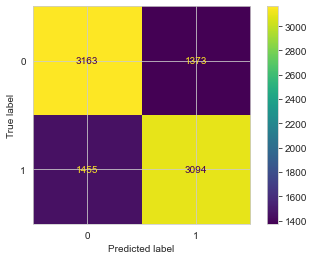

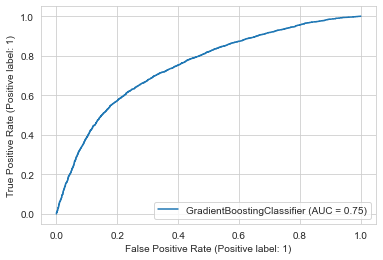

In [105]:
best_params_gb = model_implementation('GradientBoostingClassifier' , data_discretized, param_grid=param_grid)

### Prediction

In [106]:
clf_test_unseen = GradientBoostingClassifier(**best_params_gb)

In [107]:
X = data_discretized.drop(columns=['Disease'])

y = data_discretized['Disease']

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=1,
    shuffle=True,
    stratify=y
)

In [108]:
clf_test_unseen.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1           1.3293           52.78s
         2           1.2820           53.25s
         3           1.2419           51.03s
         4           1.2084           49.91s
         5           1.1798           48.42s
         6           1.1548           47.58s
         7           1.1330           47.39s
         8           1.1145           47.12s
         9           1.0981           47.22s
        10           1.0834           47.09s
        11           1.0698           46.98s
        12           1.0587           46.64s
        13           1.0485           46.19s
        14           1.0391           46.22s
        15           1.0309           45.91s
        16           1.0231           45.76s
        17           1.0159           45.73s
        18           1.0100           45.32s
        19           1.0043           45.06s
        20           0.9998           44.57s
        21           0.9950           44.35s
        2

       188           0.7162           30.27s
       189           0.7144           30.26s
       190           0.7121           30.31s
       191           0.7104           30.30s
       192           0.7095           30.26s
       193           0.7090           30.19s
       194           0.7080           30.15s
       195           0.7073           30.10s
       196           0.7069           30.03s
       197           0.7058           29.99s
       198           0.7052           29.94s
       199           0.7039           29.90s
       200           0.7030           29.86s
       201           0.7020           29.82s
       202           0.7012           29.75s
       203           0.6993           29.75s
       204           0.6976           29.75s
       205           0.6958           29.73s
       206           0.6945           29.71s
       207           0.6938           29.66s
       208           0.6918           29.66s
       209           0.6915           29.61s
       210

       375           0.5229           24.32s
       376           0.5221           24.28s
       377           0.5209           24.26s
       378           0.5201           24.23s
       379           0.5194           24.19s
       380           0.5188           24.14s
       381           0.5184           24.10s
       382           0.5180           24.05s
       383           0.5168           24.02s
       384           0.5165           23.97s
       385           0.5155           23.94s
       386           0.5149           23.91s
       387           0.5141           23.87s
       388           0.5136           23.83s
       389           0.5129           23.79s
       390           0.5118           23.76s
       391           0.5105           23.74s
       392           0.5096           23.71s
       393           0.5084           23.68s
       394           0.5076           23.65s
       395           0.5065           23.62s
       396           0.5063           23.57s
       397

       559           0.3893           17.79s
       560           0.3887           17.75s
       561           0.3878           17.71s
       562           0.3876           17.67s
       563           0.3868           17.64s
       564           0.3862           17.60s
       565           0.3857           17.56s
       566           0.3854           17.52s
       567           0.3846           17.48s
       568           0.3837           17.45s
       569           0.3827           17.42s
       570           0.3820           17.38s
       571           0.3814           17.34s
       572           0.3813           17.29s
       573           0.3808           17.26s
       574           0.3800           17.22s
       575           0.3794           17.19s
       576           0.3787           17.14s
       577           0.3779           17.11s
       578           0.3773           17.07s
       579           0.3765           17.04s
       580           0.3755           17.01s
       581

       743           0.2955           10.64s
       744           0.2949           10.60s
       745           0.2945           10.57s
       746           0.2941           10.53s
       747           0.2936           10.49s
       748           0.2930           10.45s
       749           0.2924           10.41s
       750           0.2920           10.37s
       751           0.2912           10.33s
       752           0.2904           10.30s
       753           0.2899           10.26s
       754           0.2895           10.22s
       755           0.2890           10.18s
       756           0.2888           10.14s
       757           0.2886           10.10s
       758           0.2884           10.05s
       759           0.2881           10.01s
       760           0.2875            9.97s
       761           0.2871            9.93s
       762           0.2868            9.89s
       763           0.2865            9.85s
       764           0.2858            9.81s
       765

       928           0.2272            3.06s
       929           0.2267            3.02s
       930           0.2264            2.98s
       931           0.2260            2.94s
       932           0.2256            2.89s
       933           0.2254            2.85s
       934           0.2252            2.81s
       935           0.2248            2.77s
       936           0.2245            2.73s
       937           0.2242            2.68s
       938           0.2240            2.64s
       939           0.2237            2.60s
       940           0.2233            2.56s
       941           0.2230            2.51s
       942           0.2227            2.47s
       943           0.2223            2.43s
       944           0.2219            2.39s
       945           0.2215            2.35s
       946           0.2211            2.30s
       947           0.2209            2.26s
       948           0.2207            2.22s
       949           0.2205            2.18s
       950

GradientBoostingClassifier(criterion='mse', max_depth=10, max_features='sqrt',
                           min_samples_leaf=3, min_samples_split=10,
                           n_estimators=1000, verbose=3)

In [109]:
y_pred_gb = clf_test_unseen.predict(data_discretized_test)

### Prediction Results

In [112]:
predictions = pd.DataFrame(zip(id_, y_pred_nb, y_pred_knn, y_pred_rf, y_pred_gb), columns=['ID', 'NBC', 'KNN', 'RF', 'GBM'])

In [113]:
predictions.to_csv('predictions.csv', index=False)

In [118]:
for col in predictions.columns[1:]:
    print(f"{col}: {predictions[col].value_counts()}")

NBC: 0    14297
1     6703
Name: NBC, dtype: int64
KNN: 0    14661
1     6339
Name: KNN, dtype: int64
RF: 1    20964
0       36
Name: RF, dtype: int64
GBM: 1    20950
0       50
Name: GBM, dtype: int64


Interestingly, we can see that Random Forest and Gradient Boosting classifier both predicted much higher positive cases as compared to gaussian Naive Bayes or K Nearest Neighbor, this shows why their recall scores are much higher. 

## Conclusion

From the results, proper implementation of hyperparameter tuning was not done on the GradientBoostingClassifier, and although the scores from the results of this classifier are low, they can definitely be improved with adequate tuning. By setting the verbosity (verbose = 3), we are able to observe how the classifer is minizing the loss function (in our case 'mse'). We can also see that recall is extremely close to the RandomForestClassifier at 68%. To conclude, ensemble methods like RandomForest and GradientBoosting seem to outperform other classifier although there is more processing power and timer required. This is the tradeoff, especially with classifiers like Gaussian Naive Bayes.

## Additional Considerations

 * Look into other hyper parameters such as impurity (which is set to to it's default settings)
 * Convert standardized data to positive values for Complement and Multinomial NB, although this would likely have a negative impact on the results
 * Drop correlated features
 * Add function to define ranges for results of random search to be passed to grid search
 * Add function that keeps track of processing time for random and grid search
 * Add loss metrics
 * Remove more or all outliers from High and Low Blood Pressure
 * Implement bagging with decisiont tree
 
***Notes***
 * Choosing max_features < n_features leads to a reduction of variance and an increase in bias.

## References
 * https://machinelearningmastery.com/classification-as-conditional-probability-and-the-naive-bayes-algorithm/
 * https://stackoverflow.com/questions/56397128/roc-auc-score-is-different-while-calculating-using-predict-vs-predict-proba
 * https://datascience.stackexchange.com/questions/40940/why-is-sklearn-metrics-roc-auc-score-seemingly-able-to-accept-scores-on-any-sc
 * https://stackoverflow.com/questions/47742698/how-does-sklearn-calculates-the-area-under-the-roc-curve-for-a-binary-classifier
 * https://stackoverflow.com/questions/65398299/proper-inputs-for-scikit-learn-roc-auc-score-and-roc-plot
 * https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
 * https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-pandas-data-frame
 * https://scikit-learn.org/stable/auto_examples/preprocessing/plot_discretization.html#sphx-glr-auto-examples-preprocessing-plot-discretization-py
 * https://stackoverflow.com/questions/39828535/how-to-tune-gaussiannb
 * https://stackoverflow.com/questions/51194627/python-naive-bayes-with-cross-validation-using-gaussiannb-classifier
 * https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/